# Research and Experiment Notebook


In [5]:
import matplotlib
import os
from pathlib import Path as p

In [8]:
p.cwd()

PosixPath('/home/jovyan/projectDir')

In [23]:
wrkdir = p.cwd()
print(f"Current directory: {wrkdir}")

Current directory: /home/jovyan/projectDir


In [28]:
data_dir = '/home/jovyan/projectDir/umoja_hack_dataset'
print(f"Dataset directory: {data_dir}")

Dataset directory: /home/jovyan/projectDir/umoja_hack_dataset


# check the classes or categories 

In [31]:
ls '/home/jovyan/projectDir/umoja_hack_dataset'

 Actiniaria/                            Marginella_musica/
 Actinoptilum_molle/                    Marthasterias_africana/
 Actinoscyphia_plebeia/                 Mediaster_bairdi_capensis/
 Actinostola_capensis/                  Merhippolyte_agulhasensis/
 Aequorea_spp/                          Miersiograpsus_kingsleyi/
 Africolaria_rutila/                    Munida_benguela/
 Alcyonacea/                            Mursia_cristiata/
 Amalda_bullioides/                     Mycale_anisochela/
 Anthoptilum_grandiflorum/             'Nassarius speciosus'/
 Aphelodoris_sp_/                       Nassarius_vinctus/
 Aphrodita_alta/                        Neolithodes_asperrimus/
 Aristeus_varidens/                     Neopilumnoplax_heterochir/
 Armina_sp_/                            Neptuneopsis_gilchristi/
 Ascidiacea/                            Nudibranchia/
 Astropecten_irregularis_pontoporeus/   Ophiomyxa_vivipara_capensis/
 Athleta_abyssicola/                    Ophiothrix_aristulata/


# Import necessary modules 

In [42]:
import os, random 
from os.path import join
import  numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tqdm import tqdm

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(2)
random.seed=2

In [32]:
num_classes =len(os.listdir(data_dir))
num_classes

137

In [34]:
Class_Name = np.array(os.listdir(data_dir))
Class_Name

array(['Actiniaria', 'Actinoptilum_molle', 'Actinoscyphia_plebeia',
       'Actinostola_capensis', 'Aequorea_spp', 'Africolaria_rutila',
       'Alcyonacea', 'Amalda_bullioides', 'Anthoptilum_grandiflorum',
       'Aphelodoris_sp_', 'Aphrodita_alta', 'Aristeus_varidens',
       'Armina_sp_', 'Ascidiacea', 'Astropecten_irregularis_pontoporeus',
       'Athleta_abyssicola', 'Athleta_lutosa', 'Bolocera_kerguelensis',
       'Brissopsis_lyrifera_capensis', 'Bryozoa', 'Cavernularia_spp',
       'Cephalodiscus_gilchristi', 'Ceramaster_patagonicus_euryplax',
       'Charonia_lampas', 'Cheilostomatida', 'Cheiraster_hirsutus',
       'Chondraster_elattosis', 'Chrysaora_fulgida', 'Chrysaora_spp',
       'Comanthus_wahlbergii', 'Comitas_saldanhae', 'Comitas_stolida',
       'Cosmasterias_felipes', 'Crossaster_penicillatus',
       'Cypraeovula_iutsui', 'Diplopteraster_multipes',
       'Dipsacaster_sladeni_capensis', 'Echinus_gilchristi',
       'Eleutherobia_variable', 'Euspira_napus', 'Exodromi

In [35]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
image_shape = (IMG_HEIGHT,IMG_WIDTH,3)
#STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [97]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_generator = ImageDataGenerator(rescale=1./255,rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,
                                     shear_range=0.1,validation_split=0.4)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [98]:
train_data_gen = train_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(Class_Name),subset='training',
                                                    seed=2)

val_data_gen = train_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(Class_Name),subset='validation',
                                                  seed=2)

Found 1511 images belonging to 137 classes.
Found 920 images belonging to 137 classes.


In [99]:
nb_sample = 1511 
nb_val_sample =920 
batch_size =BATCH_SIZE
steps_per_epoch = nb_sample // batch_size
steps_per_epoch

47

In [100]:
def show_batch(image_batch, label_batch):

    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        #plt.title(Class_Name[label_batch[n]==1][0].title())
        plt.axis('off')

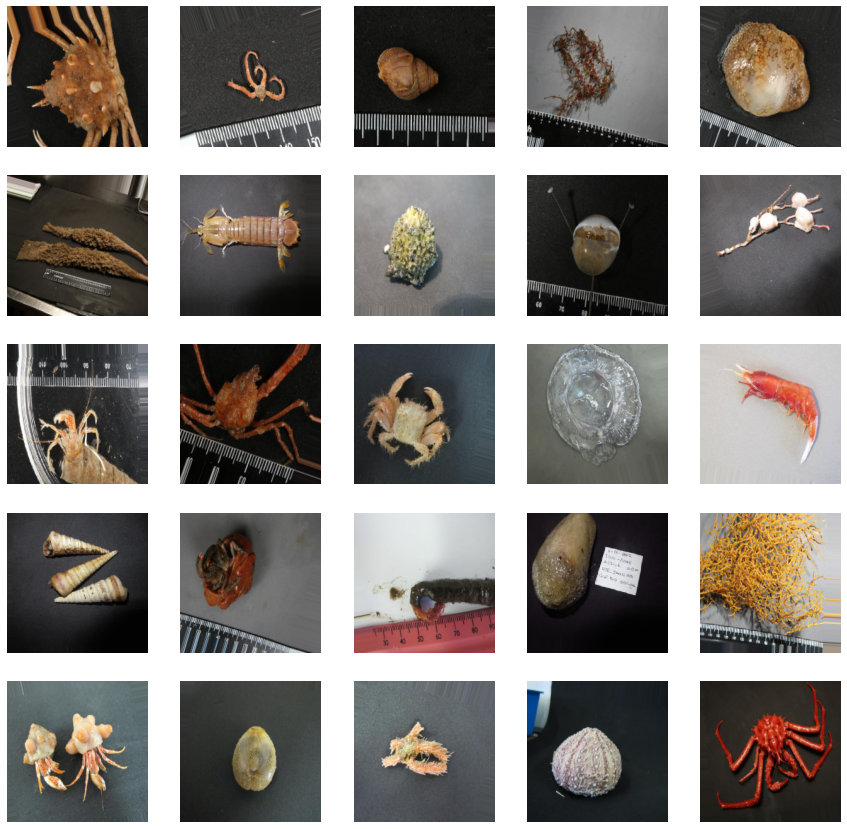

In [101]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [102]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [early_stopping,checkpoint,reduce_lr]

## Using pretrained model

In [103]:
pretrained = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [104]:
# Layers are set to trainable as True by default
for layer in pretrained.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(pretrained.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 Conv2D False
11 BatchNormalization False
12 ReLU False
13 ZeroPadding2D False
14 DepthwiseConv2D False
15 BatchNormalization False
16 ReLU False
17 Conv2D False
18 BatchNormalization False
19 Conv2D False
20 BatchNormalization False
21 ReLU False
22 DepthwiseConv2D False
23 BatchNormalization False
24 ReLU False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 ZeroPadding2D False
32 DepthwiseConv2D False
33 BatchNormalization False
34 ReLU False
35 Conv2D False
36 BatchNormalization False
37 Conv2D False
38 BatchNormalization False
39 ReLU False
40 DepthwiseConv2D False
41 BatchNormalization False
42 ReLU False
43 Conv2D False
44 BatchNormalization False
45 Add False
46 Conv2D False
47 BatchNormalization False
48 ReL

# Let's make a function that returns our FC Head

In [105]:
def addTopModelPretrained(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

# Let's add our FC Head back onto the pretrained model

In [106]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

FC_Head = addTopModelPretrained(pretrained, num_classes)

model = Model(inputs = pretrained.input, outputs = FC_Head)

print(model.summary())

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [107]:
model.compile(loss = 'categorical_crossentropy',
              # optimizer = Adam(lr=0.001),
              optimizer = 'adam',
              metrics = ['accuracy'])

In [108]:
tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [109]:
result = model.fit(train_data_gen,epochs=40,callbacks=callbacks,validation_data=val_data_gen,steps_per_epoch = steps_per_epoch,validation_steps=8)

Epoch 1/40
47/47 [==============================] - ETA: 0s - loss: 3.9530 - accuracy: 0.2096
Epoch 00001: val_loss improved from inf to 2.67047, saving model to model.h5
47/47 [==============================] - 42s 887ms/step - loss: 3.9530 - accuracy: 0.2096 - val_loss: 2.6705 - val_accuracy: 0.4570
Epoch 2/40
47/47 [==============================] - ETA: 0s - loss: 2.0039 - accuracy: 0.5490
Epoch 00002: val_loss improved from 2.67047 to 1.90194, saving model to model.h5
47/47 [==============================] - 39s 835ms/step - loss: 2.0039 - accuracy: 0.5490 - val_loss: 1.9019 - val_accuracy: 0.5156
Epoch 3/40
47/47 [==============================] - ETA: 0s - loss: 1.0493 - accuracy: 0.7606
Epoch 00003: val_loss improved from 1.90194 to 1.34428, saving model to model.h5
47/47 [==============================] - 38s 810ms/step - loss: 1.0493 - accuracy: 0.7606 - val_loss: 1.3443 - val_accuracy: 0.6562
Epoch 4/40
47/47 [==============================] - ETA: 0s - loss: 0.6646 - accura

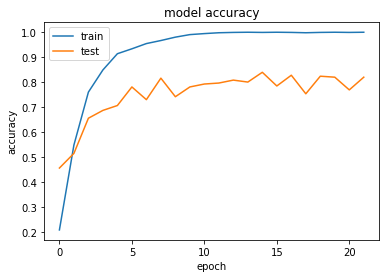

In [110]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [111]:
from tensorflow.keras.models import load_model
loadmodel = load_model('model.h5')

# convert to tensorflow serving format

In [114]:
import time 

In [115]:
ts = int(time.time())

In [117]:
loadmodel.save(filepath=f'/home/jovyan/projectDir/classifier/{ts}', save_format='tf')

INFO:tensorflow:Assets written to: /home/jovyan/projectDir/classifier/1602601313/assets
